
# HW 2 - Housing data analisys
## ECGR 5105 - Summer 2024
#### Joshua Ayers
#### SID: 801083470
#### Professor: Vinit Katariya
#### Github: https://github.com/Jayers0/HW2_ECGR5105

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split

In [56]:
df = pd.read_csv('/home/laptop/ECGR_5105/HW2/Housing.csv') 

print("Data")
df

Data


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished
...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,1820000,3000,2,1,1,yes,no,yes,no,no,2,no,unfurnished
541,1767150,2400,3,1,1,no,no,no,no,no,0,no,semi-furnished
542,1750000,3620,2,1,1,yes,no,no,no,no,0,no,unfurnished
543,1750000,2910,3,1,1,no,no,no,no,no,0,no,furnished


In [57]:

# Identify non-numerical columns
non_numeric_vars = df.select_dtypes(include=['object']).columns.tolist()
non_numeric_vars

['mainroad',
 'guestroom',
 'basement',
 'hotwaterheating',
 'airconditioning',
 'prefarea',
 'furnishingstatus']

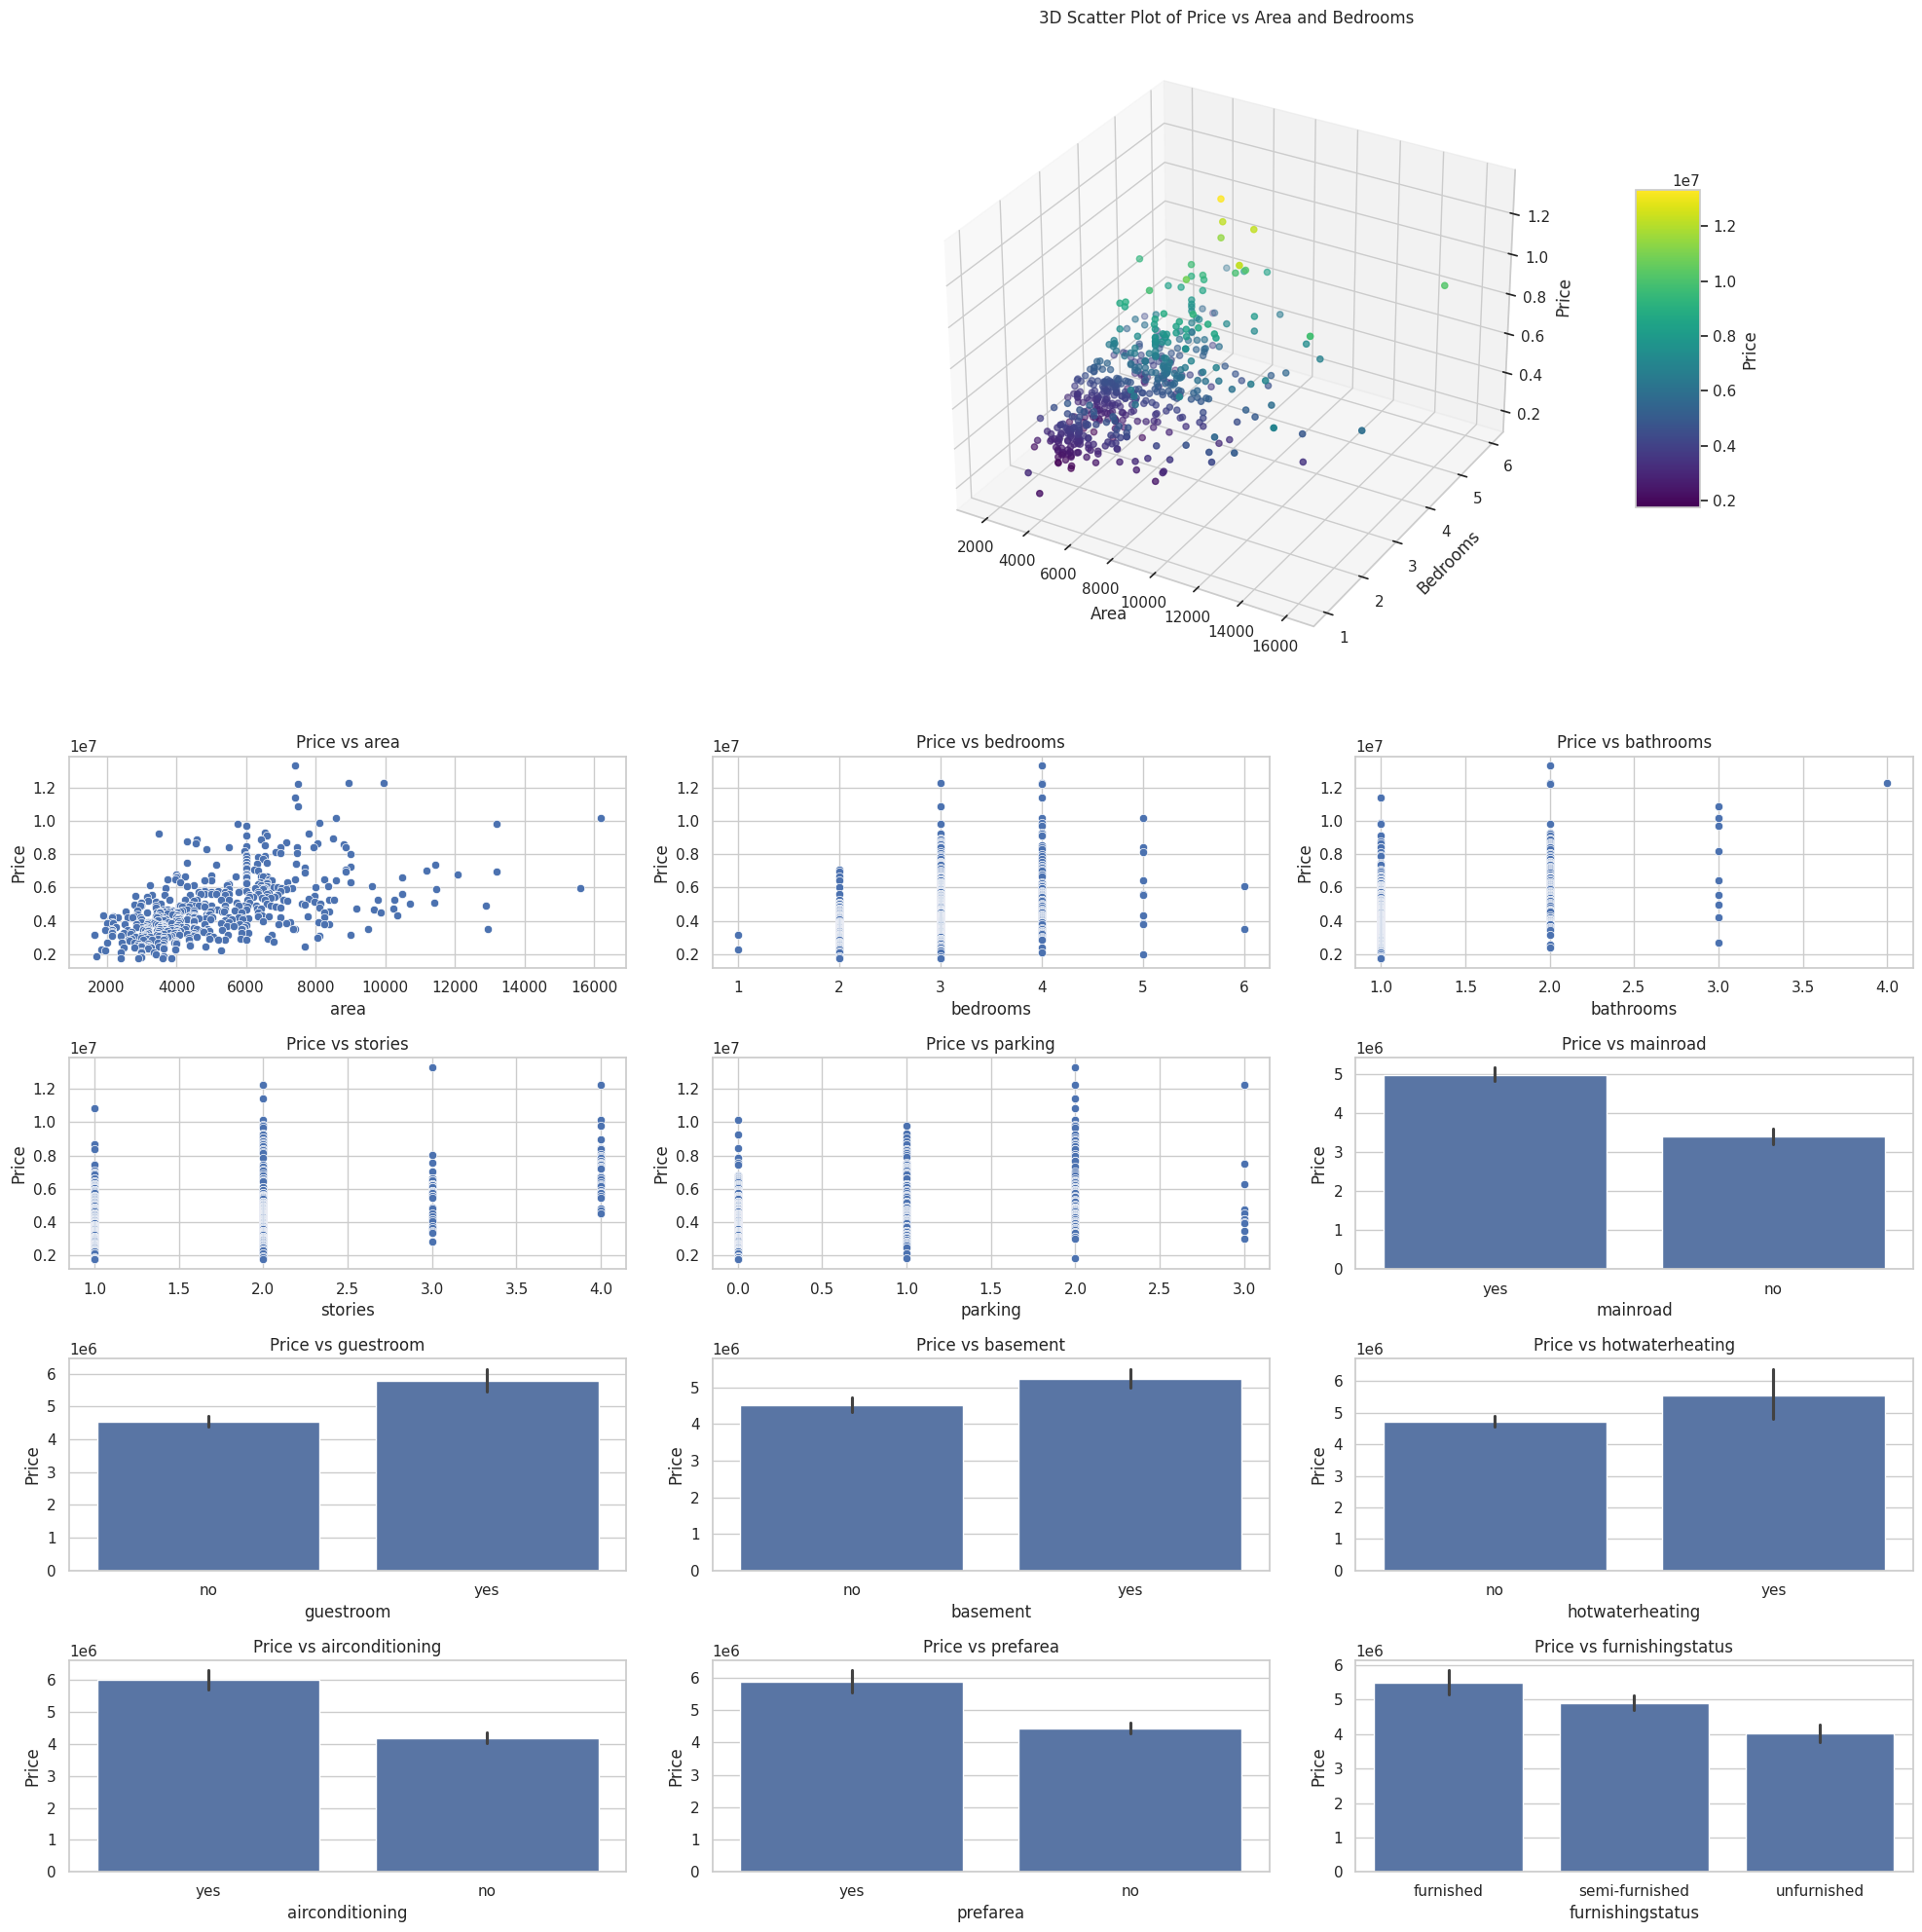

In [58]:

from mpl_toolkits.mplot3d import Axes3D

# Set the seaborn style
sns.set(style="whitegrid")


# Initialize the figure
fig = plt.figure(figsize=(20, 20))
gs = fig.add_gridspec(5, 3, height_ratios=[3, 1, 1, 1, 1])

# 3D scatter plot
ax1 = fig.add_subplot(gs[0, :], projection='3d')
scatter = ax1.scatter(df['area'], df['bedrooms'], df['price'], c=df['price'], cmap='viridis', marker='o')

# Adding labels
ax1.set_xlabel('Area')
ax1.set_ylabel('Bedrooms')
ax1.set_zlabel('Price')
ax1.set_title('3D Scatter Plot of Price vs Area and Bedrooms')

# Adding color bar
color_bar = fig.colorbar(scatter, ax=ax1, shrink=0.5, aspect=5)
color_bar.set_label('Price')

# 2D subplots for numeric variables
numeric_vars = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']
for i, var in enumerate(numeric_vars):
    row = (i // 3) + 1
    col = i % 3
    ax = fig.add_subplot(gs[row, col])
    sns.scatterplot(data=df, x=var, y='price', ax=ax)
    ax.set_xlabel(var)
    ax.set_ylabel('Price')
    ax.set_title(f'Price vs {var}')

# Additional subplots for non-numerical variables
non_numeric_vars = df.select_dtypes(include=['object']).columns.tolist()
for i, var in enumerate(non_numeric_vars):
    row = ((i + len(numeric_vars)) // 3) + 1
    col = (i + len(numeric_vars)) % 3
    ax = fig.add_subplot(gs[row, col])
    sns.barplot(x=var, y='price', data=df, ax=ax)
    ax.set_xlabel(var)
    ax.set_ylabel('Price')
    ax.set_title(f'Price vs {var}')

plt.tight_layout()
plt.show()


## Q1-A: Identify the best parameters for your linear regression model, based on the above input variables. 
The best parameters IE those with the strongest positive or negative corolation too the data is the number of stories and the furnishing status however for part 1A the relavant data will be stories.

A function for ploting training plots and losses

In [59]:
# Function to plot training and validation losses
def plot_losses(train_losses, val_losses, title):
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(train_losses)), train_losses, label='Training Loss')
    plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.show()

# Problem 1

## A)

The following code is an implementation of the required functions for logistic regresion
The sigmoid opperatot is used as the gradient mediating funtion to avoid exploding and diminishing gradients
The mathmatical formula is shown in the formula below: $$\sigma(z) = \frac{1}{1+e^{-z}}$$

In [60]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

The next formula is the log cost function and is an expantion of the log cost function. $$J(\theta) = \frac{1}{m}\sum^{m}_{i=1}Err(h_{\theta}(x^{(i)}),y^{i})$$ 
Note that the $y^{(i)} \neq y^i $ but rather denotes the item of the dataset by the indicies $i:i\in S : S \text{ is a dataset} \land m =\text{the cardonality of S}$. $$ $$
The $Err(h(\theta),y)$ function shown above is the logarithmic nonlinear function that represents the Euclidian cost function ($h(\theta)$).
It is equal to the following mathmatical expression: $$Err(h_\theta(x),y) = (1-y)\log(1-h_{\theta}(x))-y\log(h_\theta(x))$$
For the purposes of this assignment I will use the sigmoid opperator($\sigma$) as the cost function($h(x)$) both becuase it was the example used in class and because it has no distrabution bias.



In [61]:
def computeCost(X, y, theta):
    m = len(y)
    h = sigmoid(np.dot(X, theta))
    epsilon = 1e-5
    cost = (1/m) * ( -y.T @ np.log(h + epsilon) - (1 - y).T @ np.log(1 - h + epsilon))
    return cost

The next formula is the gradient decent algorithum. This function is a composite of the partial dirivative of the log cost funtion in all dimentions ($\text{gradient denoted as }\nabla$) in respect to the independednt variable. As shown below where F is a hypothetical cost funtion
$$a_{n+1}=a_{n}-\gamma_{n}\nabla F(a_{n})$$

In [62]:
def gradientDescent(X, y, theta, learning_rate, iterations):
    m = len(y)
    cost_history = np.zeros(iterations)
    
    for i in range(iterations):
        h = sigmoid(np.dot(X, theta))
        gradient = np.dot(X.T, (h - y)) / m
        theta -= learning_rate * gradient
        cost_history[i] = computeCost(X, y, theta)
    
    return theta, cost_history



Finally the logicstic regresion combines the all of the logistics cost function the sigmoid and the gradient decent and the gradient decent algorithum.


In [63]:
def logisticRegression(X, y, learning_rate=0.01, iterations=1000):
    X = np.insert(X, 0, 1, axis=1)  # Add intercept term
    theta = np.zeros(X.shape[1])
    theta, cost_history = gradient_descent(X, y, theta, learning_rate, iterations)
    return theta, cost_history

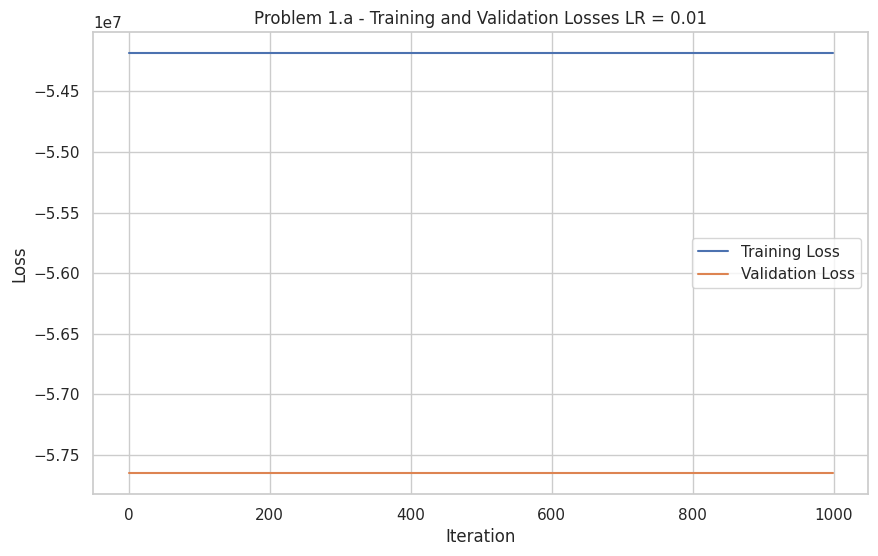

In [64]:
# Select features and target variable
features_1a = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']
X_1a = df[features_1a].values
y_1a = df['price'].values.reshape(-1, 1)

# Split data into training and validation sets
X_train_1a, X_val_1a, y_train_1a, y_val_1a = train_test_split(X_1a, y_1a, test_size=0.2, random_state=42)

# Add intercept term
X_train_1a = np.c_[np.ones(X_train_1a.shape[0]), X_train_1a]
X_val_1a = np.c_[np.ones(X_val_1a.shape[0]), X_val_1a]

# Initialize parameters
theta_1a = np.zeros((X_train_1a.shape[1], 1))
alpha = 0.01
num_iters = 1000

# Train the model
theta_1a, train_losses_1a = gradientDescent(X=X_train_1a, y= y_train_1a, learning_rate=0.01, iterations=num_iters, theta=theta_1a)
_, val_losses_1a = gradientDescent(X_val_1a, y_val_1a, learning_rate=0.01, iterations=num_iters, theta= theta_1a)

plot_losses(train_losses_1a, val_losses_1a, 'Problem 1.a - Training and Validation Losses LR = 0.01')

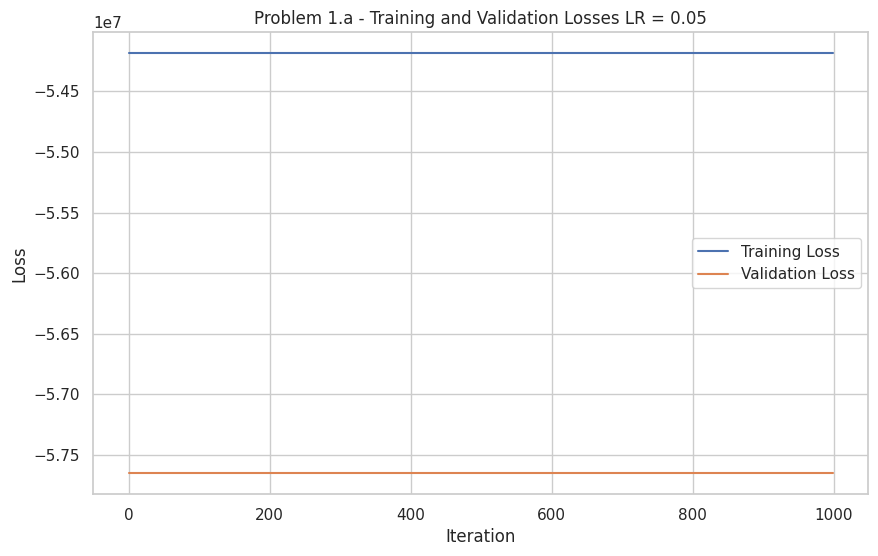

In [65]:
# Initialize parameters
theta_1a = np.zeros((X_train_1a.shape[1], 1))

num_iters = 1000

# Train the model
theta_1a, train_losses_1a = gradientDescent(X=X_train_1a, y= y_train_1a, learning_rate=0.05, iterations=num_iters, theta=theta_1a)
_, val_losses_1a = gradientDescent(X_val_1a, y_val_1a, learning_rate=0.05, iterations=num_iters, theta= theta_1a)

plot_losses(train_losses_1a, val_losses_1a, 'Problem 1.a - Training and Validation Losses LR = 0.05')

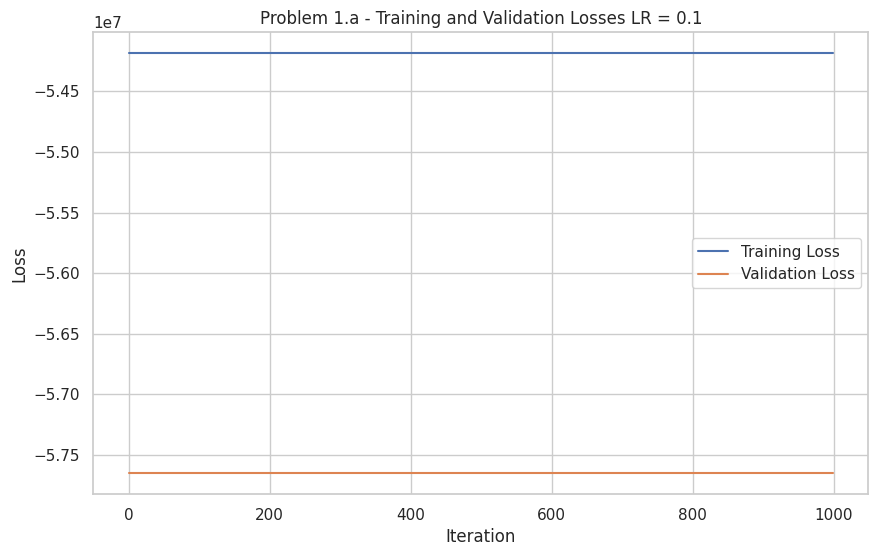

In [66]:
# Initialize parameters
theta_1a = np.zeros((X_train_1a.shape[1], 1))

num_iters = 1000

# Train the model
theta_1a, train_losses_1a = gradientDescent(X=X_train_1a, y= y_train_1a, learning_rate=0.1, iterations=num_iters, theta=theta_1a)
_, val_losses_1a = gradientDescent(X_val_1a, y_val_1a, learning_rate=0.1, iterations=num_iters, theta= theta_1a)

plot_losses(train_losses_1a, val_losses_1a, 'Problem 1.a - Training and Validation Losses LR = 0.1')

Given the above lack of convergence I tried training for other 10000 epochs at 0.001 learning rate to see if there would be any convergence and none was seen.



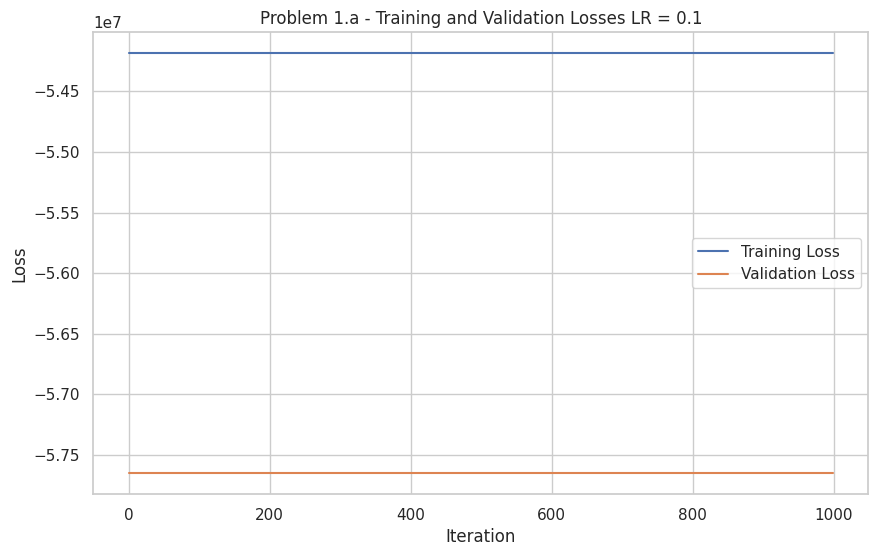

In [67]:
# Initialize parameters
theta_1a = np.zeros((X_train_1a.shape[1], 1))

num_iters = 1000

# Train the model
theta_1a, train_losses_1a = gradientDescent(X=X_train_1a, y= y_train_1a, learning_rate=0.1, iterations=num_iters, theta=theta_1a)
_, val_losses_1a = gradientDescent(X_val_1a, y_val_1a, learning_rate=0.001, iterations=num_iters, theta= theta_1a)

plot_losses(train_losses_1a, val_losses_1a, 'Problem 1.a - Training and Validation Losses LR = 0.1')

## B)

In [68]:
# Function to normalize the data
def normalize(X):
    return (X - X.min()) / (X.max() - X.min())

# Function to standardize the data
def standardize(X):
    return (X - X.mean()) / X.std()

In [69]:
# Select features and target variable
features_1b = ['Area', 'bedrooms', 'bathrooms', 'stories', 'mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'parking', 'prefarea']
X_1b = df[features_1a].values
y_1b = df['price'].values.reshape(-1, 1)

X_train_1b, X_val_1b, y_train_1b, y_val_1b = train_test_split(X_1b, y_1b, test_size=0.2, random_state=42)
theta_1b = np.zeros((X_train_1b.shape[1], 1))


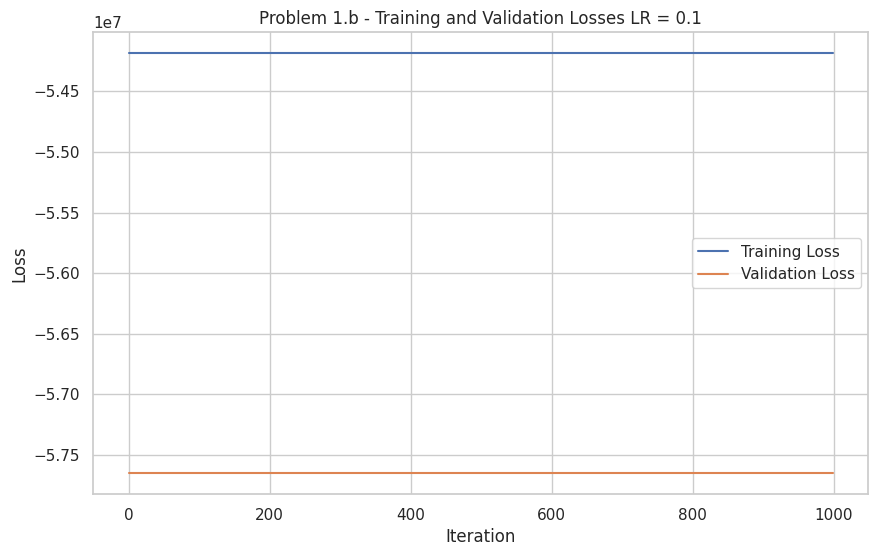

In [70]:
# Train the model
theta_1b, train_losses_1b = gradientDescent(X=X_train_1b, y= y_train_1b, learning_rate=0.1, iterations=num_iters, theta=theta_1b)
_, val_losses_1a = gradientDescent(X_val_1b, y_val_1b, learning_rate=0.1, iterations=num_iters, theta= theta_1b)

plot_losses(train_losses_1a, val_losses_1a, 'Problem 1.b - Training and Validation Losses LR = 0.1')

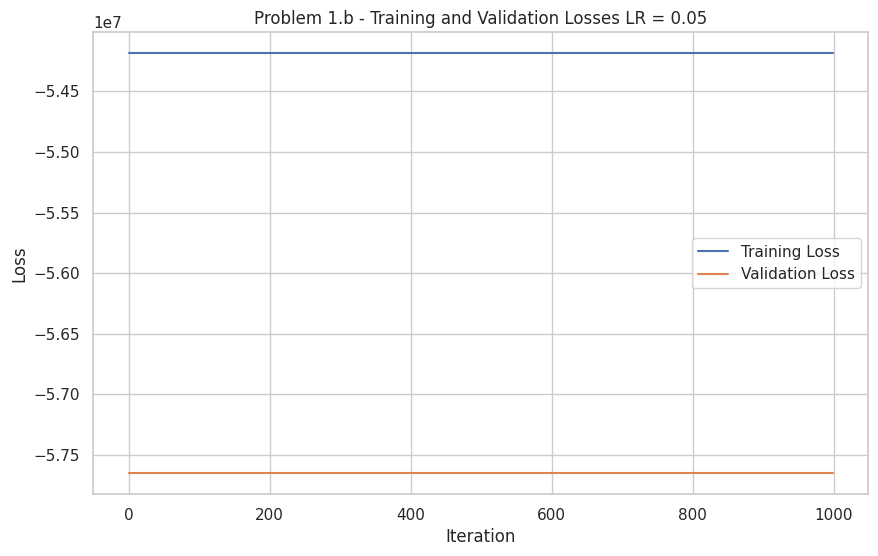

In [71]:
# Train the model
theta_1b, train_losses_1b = gradientDescent(X=X_train_1b, y= y_train_1b, learning_rate=0.05, iterations=num_iters, theta=theta_1b)
_, val_losses_1a = gradientDescent(X_val_1b, y_val_1b, learning_rate=0.05, iterations=num_iters, theta= theta_1b)

plot_losses(train_losses_1a, val_losses_1a, 'Problem 1.b - Training and Validation Losses LR = 0.05')

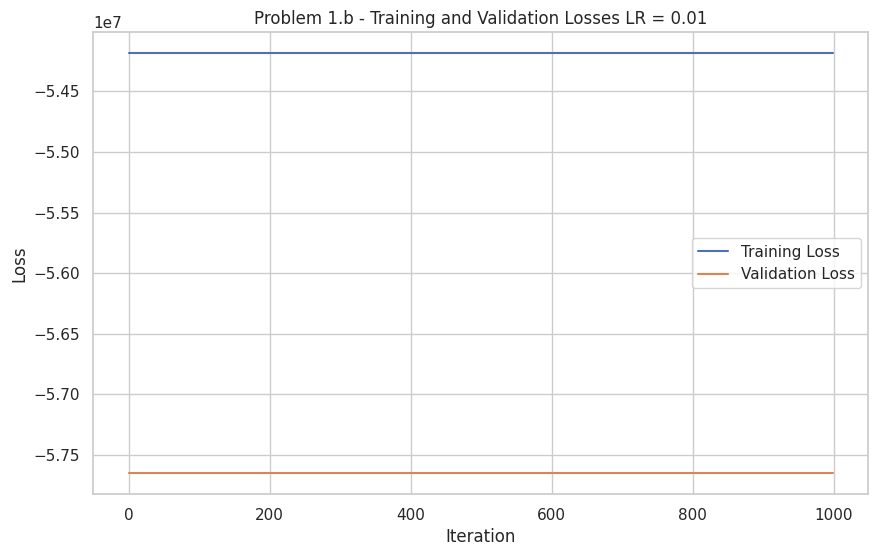

In [72]:
# Train the model
theta_1b, train_losses_1b = gradientDescent(X=X_train_1b, y= y_train_1b, learning_rate=0.01, iterations=num_iters, theta=theta_1b)
_, val_losses_1a = gradientDescent(X_val_1b, y_val_1b, learning_rate=0.01, iterations=num_iters, theta= theta_1b)

plot_losses(train_losses_1a, val_losses_1a, 'Problem 1.b - Training and Validation Losses LR = 0.01')

Including standardization there was no notable convergence.

# Problem 2
## A)

Implemnt the normalization and standardization function.
$$N(X)=\frac{X_i-\left \lceil{x}\right \rceil }{\left \lceil{x}\right \rceil - \lfloor{X}\rfloor}$$
$$S(X)=\frac{X_i-average(x)}{std(X)}$$

In [73]:
# Function to normalize the data
def normalize(X):
    return (X - X.min()) / (X.max() - X.min())

# Function to standardize the data
def standardize(X):
    return (X - X.mean()) / X.std()

#### Preprecessing the data

Creating normalized data

In [74]:
X_train_norm = normalize(X_train_1a[:, 1:])
X_val_norm = normalize(X_val_1a[:, 1:])
X_train_norm = np.c_[np.ones(X_train_norm.shape[0]), X_train_norm]
X_val_norm = np.c_[np.ones(X_val_norm.shape[0]), X_val_norm]


Creating standardized data

In [75]:
X_train_std = standardize(X_train_1a[:, 1:])
X_val_std = standardize(X_val_1a[:, 1:])
X_train_std = np.c_[np.ones(X_train_std.shape[0]), X_train_std]
X_val_std = np.c_[np.ones(X_val_std.shape[0]), X_val_std]


Running the training 

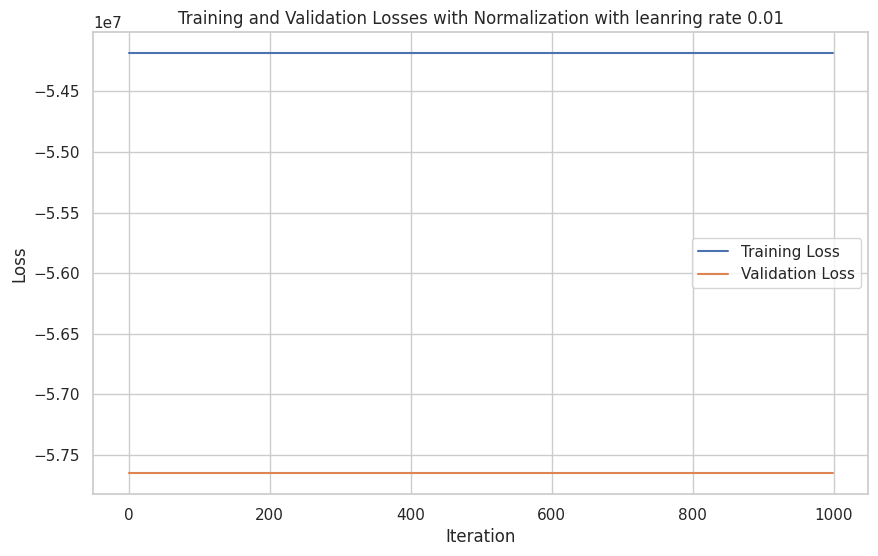

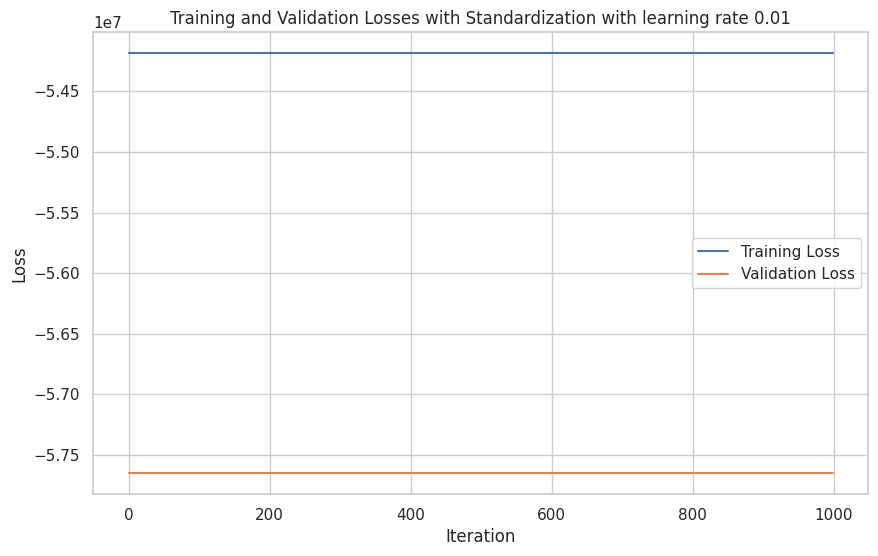

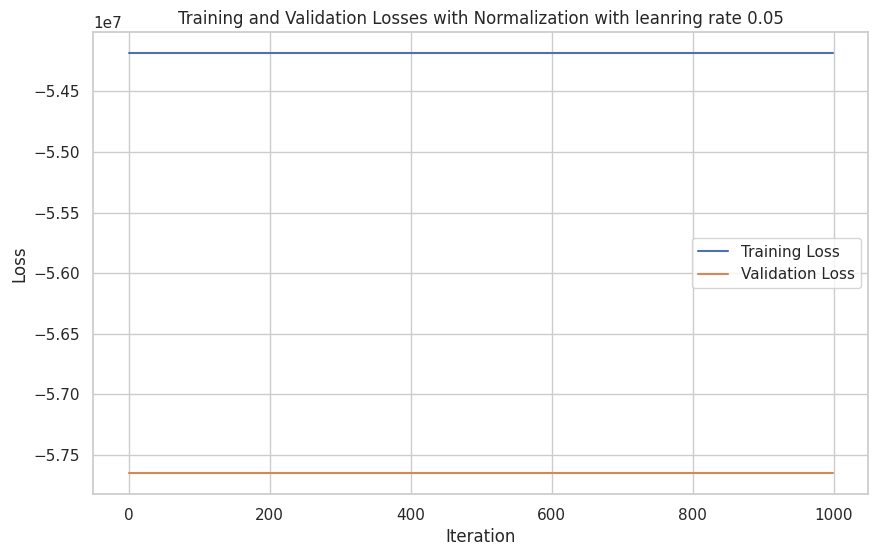

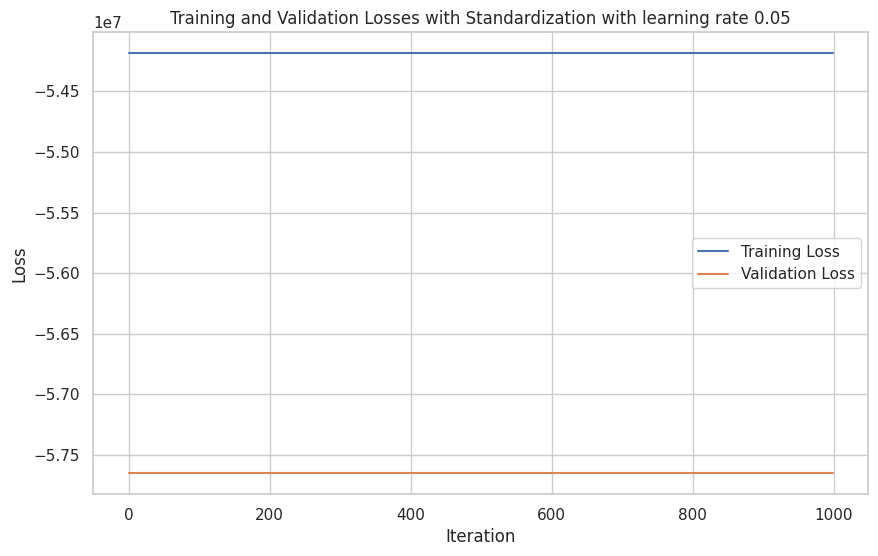

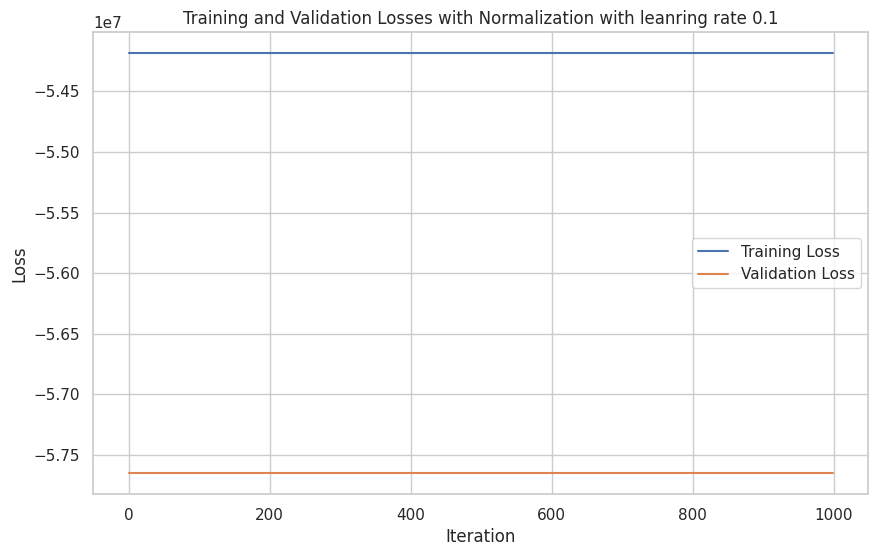

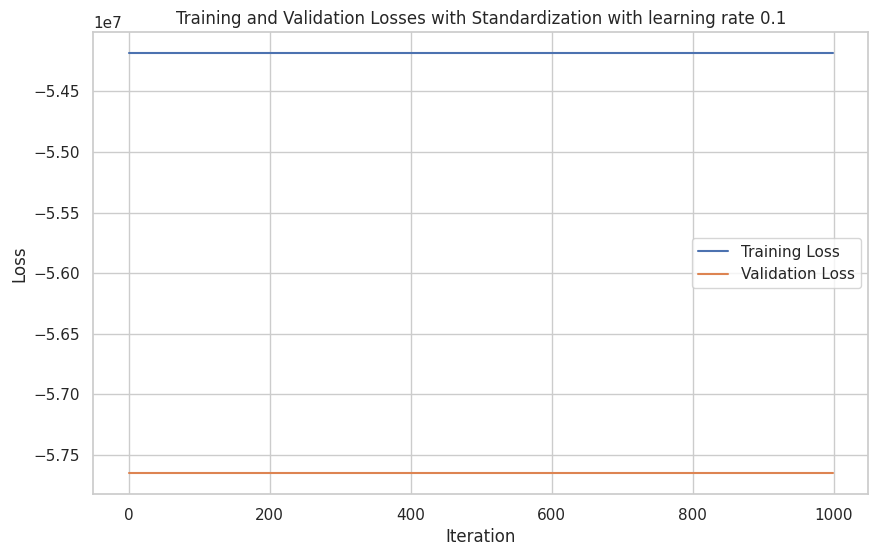

In [76]:
# Assuming alpha and num_iters are already defined somewhere in your code, e.g.:
learningRates = [0.01,0.05,0.1]
num_iters = 1000
for r in learningRates:
    # Normalization
    X_train_norm = normalize(X_train_1a[:, 1:])
    X_val_norm = normalize(X_val_1a[:, 1:])
    X_train_norm = np.c_[np.ones(X_train_norm.shape[0]), X_train_norm]
    X_val_norm = np.c_[np.ones(X_val_norm.shape[0]), X_val_norm]

    # Standardization
    X_train_std = standardize(X_train_1a[:, 1:])
    X_val_std = standardize(X_val_1a[:, 1:])
    X_train_std = np.c_[np.ones(X_train_std.shape[0]), X_train_std]
    X_val_std = np.c_[np.ones(X_val_std.shape[0]), X_val_std]

    # Gradient Descent with Normalized Data
    theta_norm = np.zeros((X_train_norm.shape[1], 1))
    theta_norm, train_losses_norm = gradientDescent(X_train_norm, y_train_1a, theta_norm, r, num_iters)
    _, val_losses_norm = gradientDescent(X_val_norm, y_val_1a, theta_norm, r, num_iters)
    plot_losses(train_losses_norm, val_losses_norm, f'Training and Validation Losses with Normalization with leanring rate {r}')

    # Gradient Descent with Standardized Data
    theta_std = np.zeros((X_train_std.shape[1], 1))
    theta_std, train_losses_std = gradientDescent(X_train_std, y_train_1a, theta_std, r, num_iters)
    _, val_losses_std = gradientDescent(X_val_std, y_val_1a, theta_std, r, num_iters)
    plot_losses(train_losses_std, val_losses_std, f'Training and Validation Losses with Standardization with learning rate {r}')


## B)

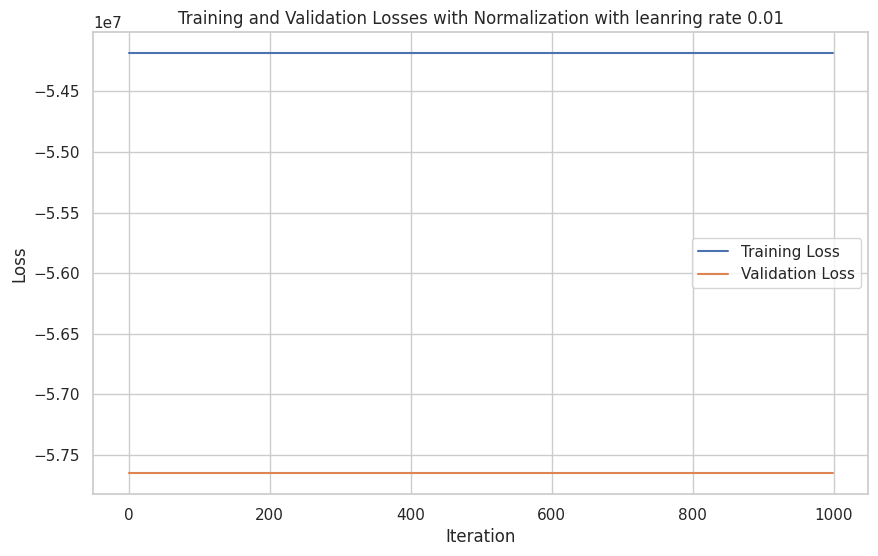

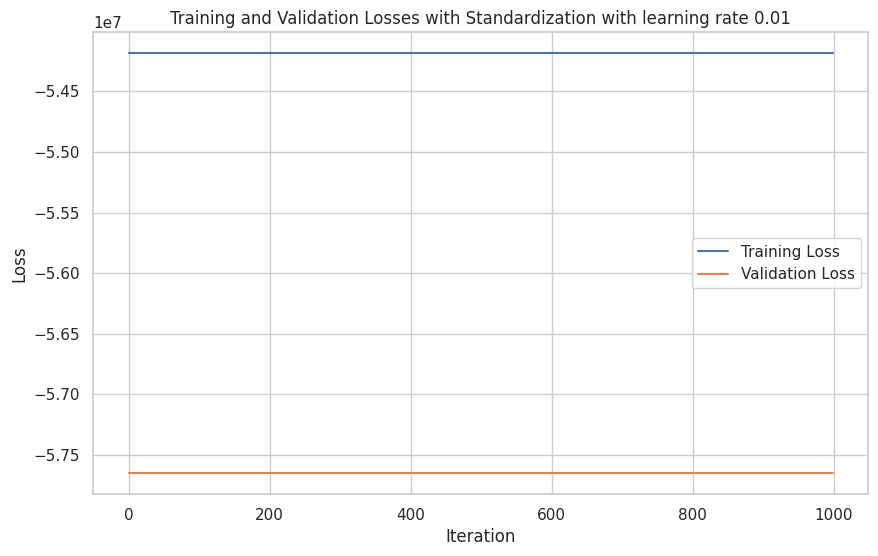

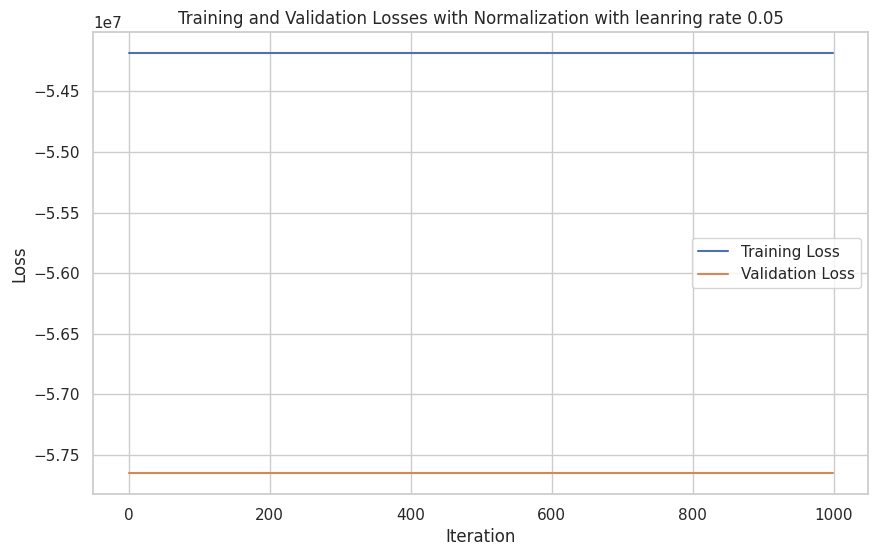

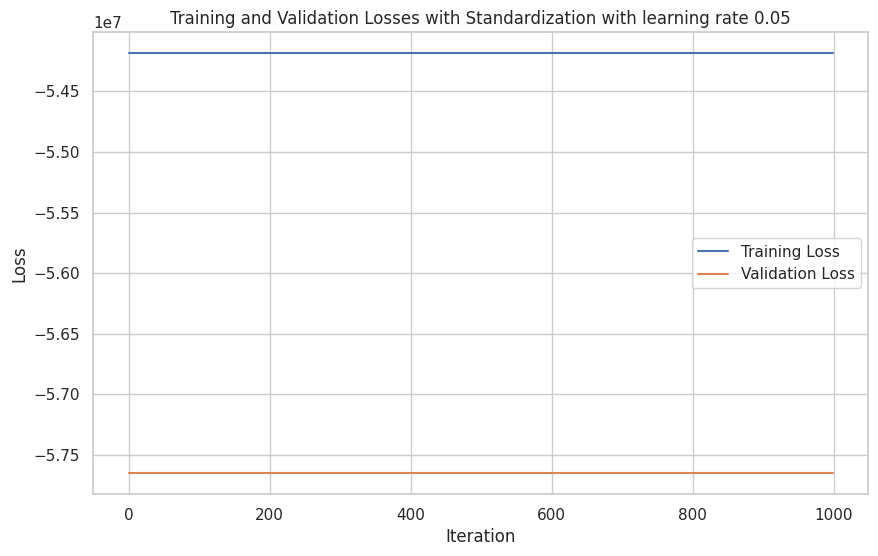

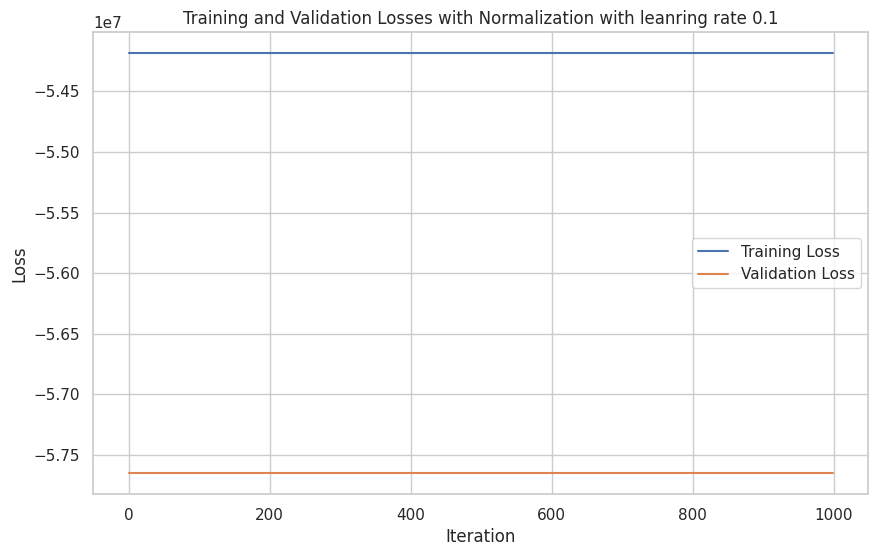

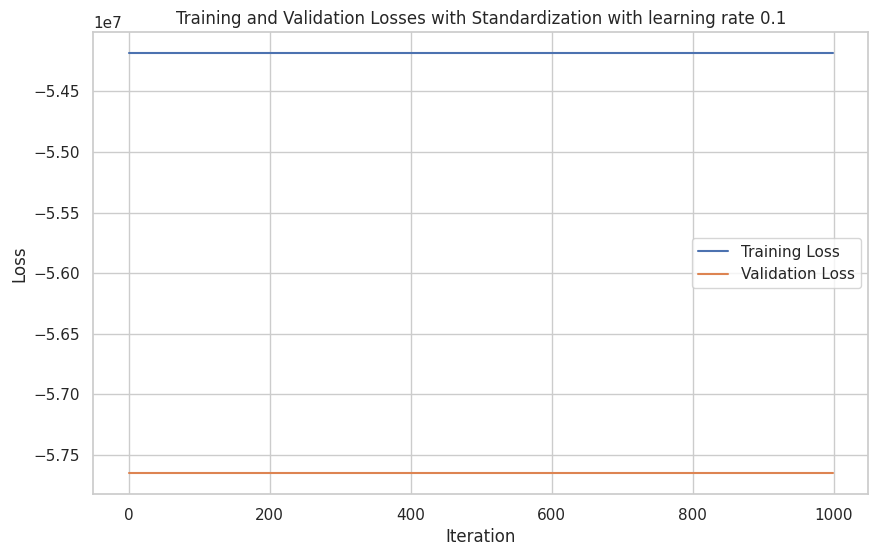

In [77]:

for r in learningRates:
    # Normalization
    X_train_norm = normalize(X_train_1b[:, 1:])
    X_val_norm = normalize(X_val_1b[:, 1:])
    X_train_norm = np.c_[np.ones(X_train_norm.shape[0]), X_train_norm]
    X_val_norm = np.c_[np.ones(X_val_norm.shape[0]), X_val_norm]

    # Standardization
    X_train_std = standardize(X_train_1b[:, 1:])
    X_val_std = standardize(X_val_1b[:, 1:])
    X_train_std = np.c_[np.ones(X_train_std.shape[0]), X_train_std]
    X_val_std = np.c_[np.ones(X_val_std.shape[0]), X_val_std]

    # Gradient Descent with Normalized Data
    theta_norm = np.zeros((X_train_norm.shape[1], 1))
    theta_norm, train_losses_norm = gradientDescent(X_train_norm, y_train_1a, theta_norm, r, num_iters)
    _, val_losses_norm = gradientDescent(X_val_norm, y_val_1b, theta_norm, r, num_iters)
    plot_losses(train_losses_norm, val_losses_norm, f'Training and Validation Losses with Normalization with leanring rate {r}')

    # Gradient Descent with Standardized Data
    theta_std = np.zeros((X_train_std.shape[1], 1))
    theta_std, train_losses_std = gradientDescent(X_train_std, y_train_1a, theta_std, r, num_iters)
    _, val_losses_std = gradientDescent(X_val_std, y_val_1b, theta_std, r, num_iters)
    plot_losses(train_losses_std, val_losses_std, f'Training and Validation Losses with Standardization with learning rate {r}')

# Problem 3
## A)

Emplement of the regularized gradient decenct algorithum.
$$
J(\theta) = \frac{1}{2m} \left[ \sum_{i=1}^{m} (h_\theta(x^{(i)}) - y^{(i)})^2 + \lambda \sum_{j=1}^{n} \theta_j^2 \right]
$$
$$\theta_j := \theta_j - \alpha \left( \frac{1}{m} \sum_{i=1}^{m} (h_\theta(x^{(i)}) - y^{(i)}) x_j^{(i)} + \frac{\lambda}{m} \theta_j \right)$$

In [78]:
# Gradient Descent function with regularization
def gradient_descent_reg(X, y, theta, alpha, num_iters, lambda_reg):
    m = len(y)
    j = []

    for i in range(num_iters):
        predictions = X.dot(theta)
        errors = predictions - y
        cost = (1/(2*m)) * (np.dot(errors.T, errors) + lambda_reg * np.sum(np.square(theta[1:])))
        j.append(cost.item())

        gradient = (1/m) * (X.T.dot(errors) + lambda_reg * np.r_[[[0]], theta[1:].reshape(-1,1)])
        theta = theta - alpha * gradient

    return theta, j



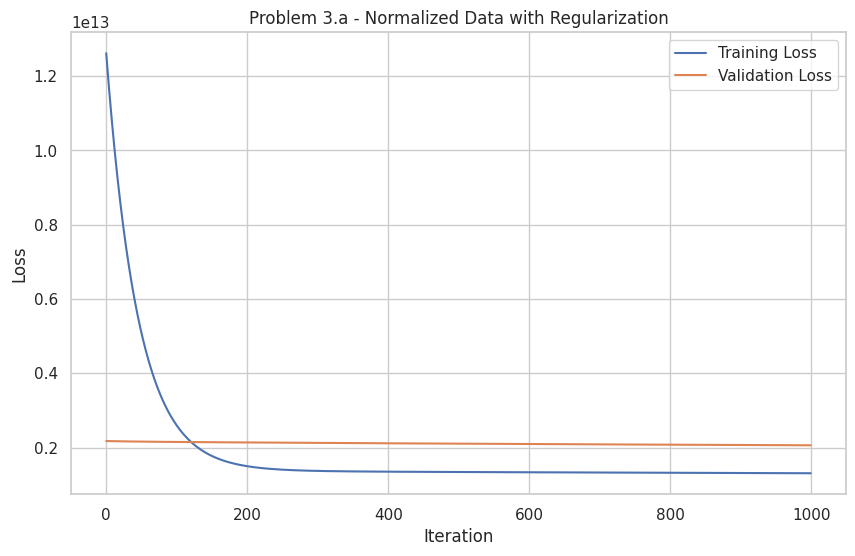

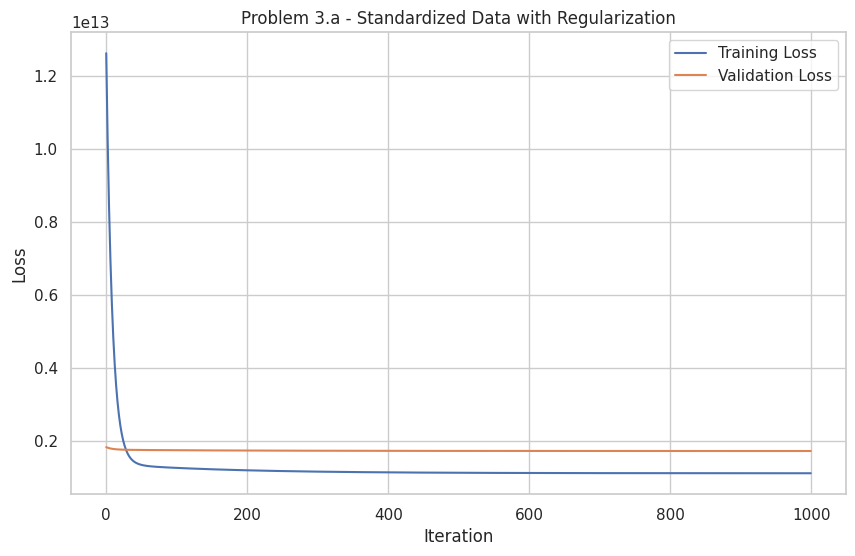

In [80]:
# Select features for problem 2.a
features = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']
X = df[features].values.astype(float)
y = df['price'].values.reshape(-1, 1).astype(float)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize and standardize the data
X_train_norm = normalize(X_train)
X_val_norm = normalize(X_val)
X_train_norm = np.c_[np.ones(X_train_norm.shape[0]), X_train_norm]
X_val_norm = np.c_[np.ones(X_val_norm.shape[0]), X_val_norm]

X_train_std = standardize(X_train)
X_val_std = standardize(X_val)
X_train_std = np.c_[np.ones(X_train_std.shape[0]), X_train_std]
X_val_std = np.c_[np.ones(X_val_std.shape[0]), X_val_std]

# Initialize parameters for normalized data with regularization
theta_norm_reg = np.zeros((X_train_norm.shape[1], 1))
lambda_reg = 1.0  # Regularization parameter
alpha = 0.01
num_iters = 1000

# Train the model with normalized data and regularization
theta_norm_reg, train_losses_norm_reg = gradient_descent_reg(X_train_norm, y_train, theta_norm_reg, alpha, num_iters, lambda_reg)
_, val_losses_norm_reg = gradient_descent_reg(X_val_norm, y_val, theta_norm_reg, alpha, num_iters, lambda_reg)

# Plot losses for normalized data with regularization
plot_losses(train_losses_norm_reg, val_losses_norm_reg, 'Problem 3.a - Normalized Data with Regularization')

# Initialize parameters for standardized data with regularization
theta_std_reg = np.zeros((X_train_std.shape[1], 1))

# Train the model with standardized data and regularization
theta_std_reg, train_losses_std_reg = gradient_descent_reg(X_train_std, y_train, theta_std_reg, alpha, num_iters, lambda_reg)
_, val_losses_std_reg = gradient_descent_reg(X_val_std, y_val, theta_std_reg, alpha, num_iters, lambda_reg)

# Plot losses for standardized data with regularization
plot_losses(train_losses_std_reg, val_losses_std_reg, 'Problem 3.a - Standardized Data with Regularization')

The standardization is data is betterin terms of its performance as you can see both have lower loss. thouhg there seems to be overfitting ocuring as the training loss is lower than validation loss

## B)

Load the data from problem 2b

In [ ]:
# Select features for problem 2.b
features_1b = ['area', 'bedrooms', 'bathrooms', 'stories', 'mainroad_yes', 'guestroom_yes', 'basement_yes', 'hotwaterheating_yes', 'airconditioning_yes', 'parking', 'prefarea_yes']
X_1b = data[features_1b].values.astype(float)
y_1b = data['price'].values.reshape(-1, 1).astype(float)

# Split data into training and validation sets
X_train_1b, X_val_1b, y_train_1b, y_val_1b = train_test_split(X_1b, y_1b, test_size=0.2, random_state=42)



like Problem 2 split and normalize and standarize data

In [ ]:
# Normalize and standardize the data
X_train_norm_1b = normalize(X_train_1b)
X_val_norm_1b = normalize(X_val_1b)
X_train_norm_1b = np.c_[np.ones(X_train_norm_1b.shape[0]), X_train_norm_1b]
X_val_norm_1b = np.c_[np.ones(X_val_norm_1b.shape[0]), X_val_norm_1b]

X_train_std_1b = standardize(X_train_1b)
X_val_std_1b = standardize(X_val_1b)
X_train_std_1b = np.c_[np.ones(X_train_std_1b.shape[0]), X_train_std_1b]
X_val_std_1b = np.c_[np.ones(X_val_std_1b.shape[0]), X_val_std_1b]



Train the model with the same parameters

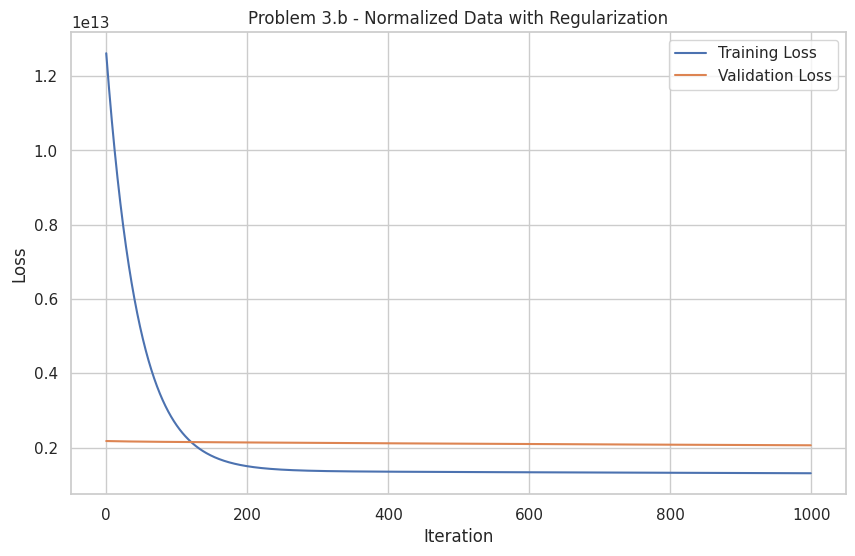

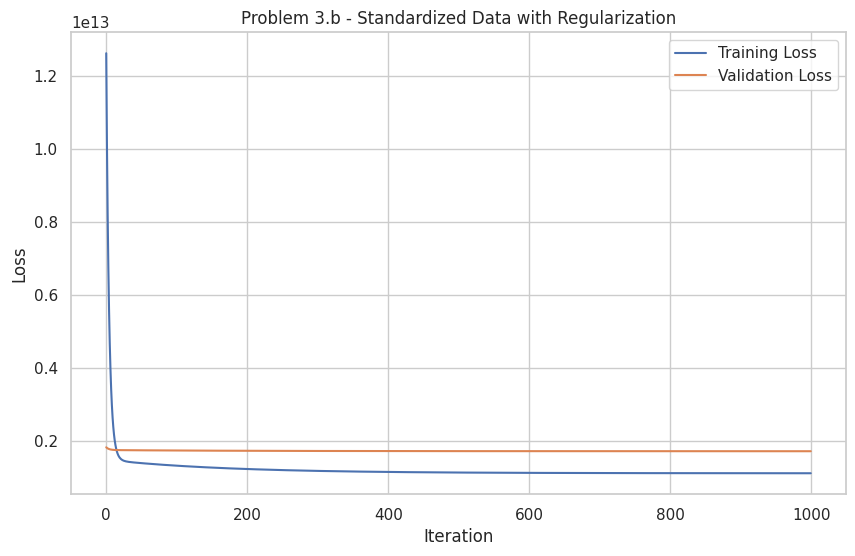

In [ ]:
# Initialize parameters for normalized data with regularization
theta_norm_1b_reg = np.zeros((X_train_norm_1b.shape[1], 1))

# Train the model with normalized data and regularization
theta_norm_1b_reg, train_losses_norm_1b_reg = gradient_descent_reg(X_train_norm_1b, y_train_1b, theta_norm_1b_reg, alpha, num_iters, lambda_reg)
_, val_losses_norm_1b_reg = gradient_descent_reg(X_val_norm_1b, y_val_1b, theta_norm_1b_reg, alpha, num_iters, lambda_reg)

# Plot losses for normalized data with regularization
plot_losses(train_losses_norm_1b_reg, val_losses_norm_1b_reg, 'Problem 3.b - Normalized Data with Regularization')

# Initialize parameters for standardized data with regularization
theta_std_1b_reg = np.zeros((X_train_std_1b.shape[1], 1))

# Train the model with standardized data and regularization
theta_std_1b_reg, train_losses_std_1b_reg = gradient_descent_reg(X_train_std_1b, y_train_1b, theta_std_1b_reg, alpha, num_iters, lambda_reg)
_, val_losses_std_1b_reg = gradient_descent_reg(X_val_std_1b, y_val_1b, theta_std_1b_reg, alpha, num_iters, lambda_reg)

# Plot losses for standardized data with regularization
plot_losses(train_losses_std_1b_reg, val_losses_std_1b_reg, 'Problem 3.b - Standardized Data with Regularization')


As with before the standardization outperforms the normalization having lower training and validation loss however both for 3a and 3b both seem to have issues with overfitting.
Dispite the diffrence that standarization and normalization should make regularizing the gradient decent algorithum seemed to make the most diffrence and allowed the model to converge.